In [18]:
MODEL_PATH = "/home/jerometh/Models_on_datasets/Models/Anger_Go_Revised.pth"
SOURCE = "Hate_2019_cleaned"
EMOTION = 'Hate'
MAX_LEN = 100
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
class_names = ['not_' + EMOTION, EMOTION]
FILE_DIR = "/home/jerometh/Tweet_Analysis/Hate_2019_Results_cleaned"


import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import pickle 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import wandb
import json 
import csv
import time
import os
import Model as md
import times as tm
import lockdown_check as lc


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("-" * 50)
print(f'using {device}')

#model = md.SentimentClassifier(len(class_names))
#md.load_checkpoint(model, torch.load(MODEL_PATH))
#model = model.to(device)

--------------------------------------------------
using cuda:0


In [20]:
lockdown = pd.read_json("timeline3.json")
not_lockdown = pd.read_json("timeline3.json")

In [21]:
print(lockdown.iloc[0])

index                          0
month                         12
start_date            2018-12-30
end_date              2019-01-05
count                          0
total                          0
percentage                 1e-07
days_from_lockdown             0
Name: 0, dtype: object


In [22]:
import torch
torch.__version__

'1.8.1'

In [23]:
for week in range(len(lockdown)):
    print(week)
    start_date = tm.get_date(lockdown.iloc[week]['start_date'])
    end_date = tm.get_date(lockdown.iloc[week]['end_date'])
    for filename in os.listdir(FILE_DIR):
        #print(filename)
        state = filename[:-5]
        #print(state)
        
        try: cur = pd.read_json(f"{FILE_DIR}/{filename}")
        except: continue
        
        
        try: status = lc.is_under_lockdown(state, start_date)
        except: continue
        
        #if lc.no_data(state): continue
            
        if lc.is_under_lockdown(state, start_date):
            lockdown.at[week, 'count'] += cur.iloc[week]['count']
            lockdown.at[week, 'total'] += cur.iloc[week]['total']
        else:
            not_lockdown.at[week, 'count'] += cur.iloc[week]['count']
            not_lockdown.at[week, 'total'] += cur.iloc[week]['total']
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


<class 'pandas.core.frame.DataFrame'>


In [24]:
def get_percentage(data):
    ma = 0
    for i in range(len(data)):

        if data['total'][i] == 0:
            continue
        else:
            data.at[i, 'percentage'] = data['count'][i]*100.00/data['total'][i]

        ma = max(ma, data['percentage'][i])
        
get_percentage(lockdown)
get_percentage(not_lockdown)

In [25]:
def plot_line(data, color, label, l, r):
    plt.plot(data['index'][l:r], data['percentage'][l:r], color = color, label = label)

In [26]:
def plot_and_save(save_to):
    
    with open(f'/home/jerometh/Tweet_Analysis/Total_Results/{save_to}_lockdown.json', 'w') as outfile:
        json.dump(lockdown.to_dict('records'), outfile)
    
    with open(f'/home/jerometh/Tweet_Analysis/Total_Results/{save_to}_not_lockdown.json', 'w') as outfile:
        json.dump(not_lockdown.to_dict('records'), outfile)
        
    fig = plt.figure()
    plot_line(not_lockdown, 'y', 'before_lockdown', 1, 65)
    plot_line(lockdown, 'r', 'lockdown', 65, 91)
    plot_line(not_lockdown, 'b', 'not_under_lockdown', 64, 91)
    plt.legend()
    plt.title(f'{EMOTION} Tweet Percentage in USA in Weeks from January 2019')
    plt.ylabel(f'{EMOTION} Tweet Percentage')
    plt.xlabel('Weeks from 2019/1/1')
    plt.xlim(1, 91)
    plt.ylim(0, )
    plt.savefig(f'/home/jerometh/Tweet_Analysis/Images_for_Paper/{save_to}.jpg', dpi = 200)
    plt.show()
    plt.clf()
    

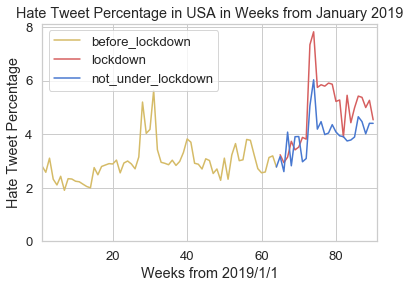

<Figure size 432x288 with 0 Axes>

In [27]:
plot_and_save(f"{EMOTION}_2019_cleaned")

In [28]:
import datetime
from datetime import timedelta


<class 'datetime.timedelta'>
1095


In [29]:
def format_func(value, tick):
    x = datetime.datetime(2020, 4, 1)
    y = datetime.datetime(2019, 1, 1)
    res = int(value - ((x - y).days)/7)
    return f'{res}'

In [30]:
def plot_line(ax, data, color, label, l, r):
    ax.plot(data['index'][l:r], data['percentage'][l:r], color = color, label = label, linewidth = 3)

In [31]:
def plot_and_save(save_to):
    fig, ax = plt.subplots()
    plot_line(ax, lockdown, 'r', 'Under Lockdown', 65, 91)
    plot_line(ax, not_lockdown, 'b', 'Not Under Lockdown', 65, 91)
    ax.set_title(f'{EMOTION} Tweet Percentage from 2020/4/1', )
    plt.xlabel('Weeks from 2020/4/1')
    plt.ylabel(f'{EMOTION} Tweet Percentage')
    plt.legend()
    plt.ylim(0, )
    plt.xlim(65, 90)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    plt.savefig(f'/home/jerometh/Tweet_Analysis/Images_for_Paper/{save_to}.jpg', dpi = 200)
    plt.show()
    plt.clf()

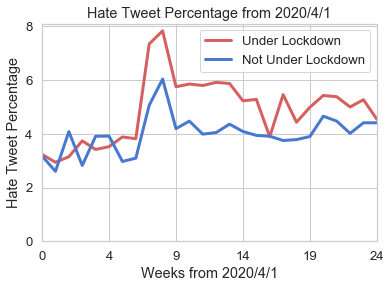

<Figure size 432x288 with 0 Axes>

In [32]:
plot_and_save(f"{EMOTION}_2020_cleaned")